## $ \hspace{7cm} \text{Learning-Based MEMS Gyrocompassing}$

####**$\text{Abstract}$**

This notebook contains the code for the inference phase, upon uploaded pre-trained model and pre-processed data, to expedite and ease understanding.

* Note that **GPU** is mandatory for the DL inferece !

* Naturally, results are likely to differ between executions due to data reshuflling or different selection of hyperparameters.

* Use *'Table of Contents'* from left for quick navigation.

Below are the technical specs of the EMCORE SDC500-AA00, will be explore and compared vs those stated by [manufacturer](chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://emcore.com/wp-content/uploads/2022/05/966762_B-SDC500.pdf). Under sampling rate of 600 [Hz], noise density of a single IMU is given by:


Error source | Specs | Noise density
-------------------|------------------|-------------------|
Angle random walk  | $$0.02 \ [\frac{\text{deg}}{\sqrt{hr}}] =  \frac{0.02}{60} [\frac{\text{deg}}{\sqrt{s}}] $$  | $$ \cdot (\sqrt{600})= 8.165 \cdot 10^{-3} \ [\frac{\text{deg}}{s}] $$
Gyro bias stability | $$ 1 \ [ \frac{\text{deg}}{hr}]$$ | $$1 \ [ \frac{\text{deg}}{hr}]$$
Velocity random walk  | $$ 100 \ [\frac{\mu g}{ \sqrt{ Hz }}] = g \ 10^{-4} = 0.1  \ \frac{\text{mg}}{\sqrt{Hz}} $$ | $$\cdot (\sqrt{600})=  0.024 \ [\frac{m}{\text{s}^2}] $$
Accel. bias stability | $$ 0.15 \ [ mg ]$$ | $$\approx 0.00147 \ [\frac{m}{s^2}]$$

"By multiplying the random walk by the **square root of time**, the standard deviation of the drift due to noise can be recovered."

### $\text{Initialization}$

#### $\text{Libraries & imports}$

In [ ]:
#@title

# ===================================================== #
#             Import from Drive Environment             #
# ===================================================== #
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib.ticker import FormatStrFormatter
!pip -q install allantools
import allantools
import warnings
warnings.filterwarnings("ignore")
import glob
from scipy import stats, signal

import os, time, torch
import torch.nn as nn

%matplotlib inline
np.random.seed(0)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(seed=42)

In [ ]:
#@title
# ===================================================== #
#                Set Working Directory                  #
# ===================================================== #

PATH_mount = '/content/gdrive'
drive.mount(PATH_mount)
PATH_process = PATH_mount + '/MyDrive/LBMCG'
os.chdir(PATH_process)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###$\text{Configuration}$

This block contains all problem-related parameters needed for the pipeline, from the sensor level to the entire navigation scheme.

In [ ]:
class CFG:
    # General
    Deg_2_Rad = (np.pi/180.0)           # [rad/deg]
    Rad_2_Deg = (180.0/np.pi)           # [deg/rad]
    hour      = 3600                    # [s]
    DegHR_2_RadSEC = np.pi/180/hour     # Deg/Hour to Rad/Sec
    mRad      = 1000
    fig_size  = (8,5)
    freq      = 600                     # [Hz] Sensor sampling rate
    dt        = 1/freq                  # [sec]

    time_limit= 230                     # Smaller than 238 [sec] (for safety)
    t_len     = time_limit*freq         # Number of time steps
    time      = np.arange(0,time_limit,dt)# [sec]

# Geodetic params
Re = 6378137                            # [m]
ecc = 0.0818191908426215                # Earth eccentricity, e2 = 2*f-f^2
E_2 = ecc**2                            # squared eccentricity
w_ie = 7292115e-11                      # Earth's rotation rate [rad]
W_ie = [0, 0, w_ie]                     # Project on INS
rad_2_deg = lambda x:x*(180/np.pi)      # Degree  to Radians
deg_2_rad = lambda x:x*(np.pi/180)      # Radians to Degree
mRad_2_deg= lambda x:x*(180/np.pi)/1000 # Radians to Degree
deg_2_mrad= lambda x:deg_2_rad(x)*1000  # Degree  to Radians
Sec_2_hr  = lambda x:x*CFG.hour         # Hours   to Seconds
Sec_2_day = lambda x: Sec_2_hr(x)*24    # Seconds to Days
w_ie_GT_Deg = rad_2_deg(w_ie)

f_norm = lambda x: np.sqrt(x@x)
f_normalize  = lambda x: (x-x.mean())/(x.max()-x.min())

### $\text{Signal Analysis}$

* Upload long stationary measurement (1 hr)

In [ ]:
paths_train = glob.glob( PATH_process + '/Data/1 Hour/*.csv', recursive = True);

X_df = [];
x_gyr_hr, x_acc_hr = [], []

df = pd.read_csv( paths_train[0], skiprows=18).iloc[:, 1:4]
df = df.loc[:, ~df.columns.str.contains('^Unnamed')].dropna(how='all').reset_index(drop=True)
x_gyr_hr = df.values

# Time vector
x_1_hr_len = df.shape[0]-1
x_1_time = np.arange(0, x_1_hr_len*CFG.dt, CFG.dt)   # [sec]

#### $\text{Allan Variance}$

In [ ]:
#@title
t_max = df.shape[0]
t_log = np.logspace( np.log10(1/CFG.freq), np.log10(t_max), 1000)

(tau_x, ad_x, _, _) = allantools.oadev(x_gyr_hr[:,0], rate=CFG.freq, data_type='freq', taus=t_log)
(tau_y, ad_y, _, _) = allantools.oadev(x_gyr_hr[:,1], rate=CFG.freq, data_type='freq', taus=t_log)
(tau_z, ad_z, _, _) = allantools.oadev(x_gyr_hr[:,2], rate=CFG.freq, data_type='freq', taus=t_log)
(t_CRLB, ad_CRLB, _, _) = allantools.oadev(np.random.randn(int(5e6)), rate=CFG.freq, data_type='freq', taus=np.logspace( np.log10(0.01), 8, 1000))

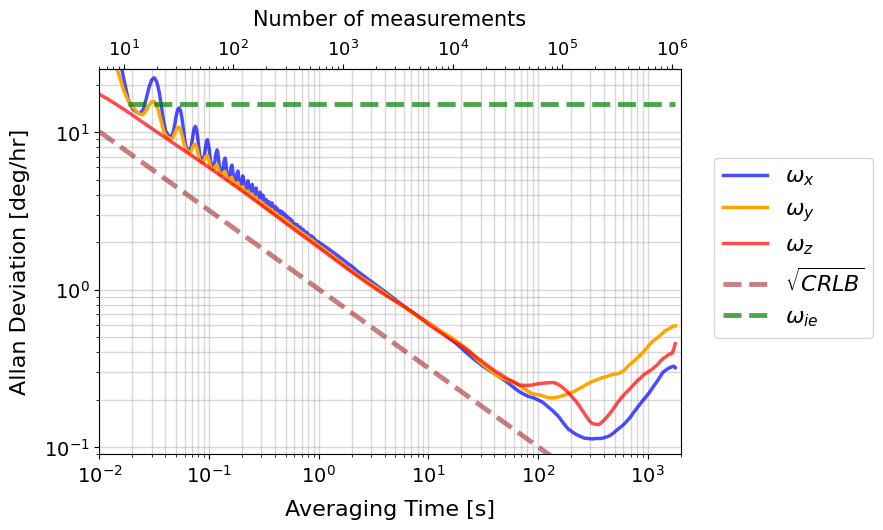

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(7.5, 5.))
ax.loglog(tau_x, ad_x*10000, linewidth=2.5, ls='-', c='blue', alpha=0.7)
ax.loglog(tau_y, ad_y*10000, linewidth=2.5, ls='-', c='orange')
ax.loglog(tau_z, ad_z*10000, linewidth=2.5, ls='-', c='r', alpha=0.7)
ax.loglog(t_CRLB, 3600*2.8e-4/np.sqrt(t_CRLB), linewidth=3.5, ls='--', c='brown', alpha=.6)
ax.axhline( 3600*w_ie_GT_Deg, 0.05, 0.99, ls='--', lw=3.5, c='g', alpha=.7)

ax.set_ylabel(r'Allan Deviation [deg/hr]', fontsize=16, labelpad=10)
ax.set_xlabel(r'Averaging Time [s]', fontsize=16, labelpad=10);
ax.tick_params(axis='both', which='major', labelsize=14)

ax.legend([r'$\omega_x$', r'$\omega_y$', r'$\omega_z$', r'$\sqrt{CRLB}$', r'$\omega_{ie}$'], loc='upper right',
          fontsize=16, fancybox=True, bbox_to_anchor=(1.35, 0.8)) # framealpha=1.,

ax.grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax.set_xlim([0.01, 2e3]); ax.set_ylim([9e-2, 25]);

secax = ax.secondary_xaxis('top', functions=(lambda x:x*CFG.freq, lambda x:x*CFG.freq))
secax.set_xlabel(r'Number of measurements', fontsize=15, labelpad=10)
secax.tick_params(axis='both', which='major', labelsize=13)

* $\text{Signal-to-Noise Ratio (SNR)}$

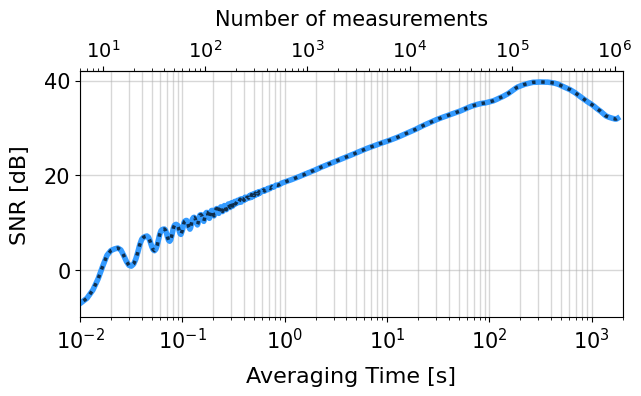

In [ ]:
#@title

mod_jump, t_ix = 10, 2
sd_lim, x_lim = 2.3, 10000

# Upload moving average & STD from local library
gyr_mn   = np.loadtxt(os.getcwd()+'/Data/x_gyr_MA.csv', delimiter=',')
gyr_sd   = np.loadtxt(os.getcwd()+'/Data/x_gyr_SD.csv', delimiter=',')

snr_skip = int(len(gyr_mn)/len(ad_x))
snr_db = 20 * np.log10(gyr_mn[t_ix::snr_skip][1:]/ad_x)-5

fig, ax = plt.subplots(figsize=(7, 3.2))
ax.semilogx( tau_x, snr_db*.85, ls='-', lw=4., c='dodgerblue', alpha=.9);
ax.semilogx( tau_x, snr_db*.85, ls=':', lw=2.5, c='k', alpha=.7);

ax.set_ylabel(r'SNR [dB]', fontsize=16, labelpad=10)
ax.set_xlabel(r'Averaging Time [s]', fontsize=16, labelpad=10);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax.set_xlim([0.01, 2e3])
# ax.set_ylim([-3, 29])

secax = ax.secondary_xaxis('top', functions=(lambda x:x*CFG.freq, lambda x:x*CFG.freq))
secax.set_xlabel(r'Number of measurements', fontsize=15, labelpad=10)
secax.tick_params(axis='both', which='major', labelsize=14)

* $\text{Error stability}$

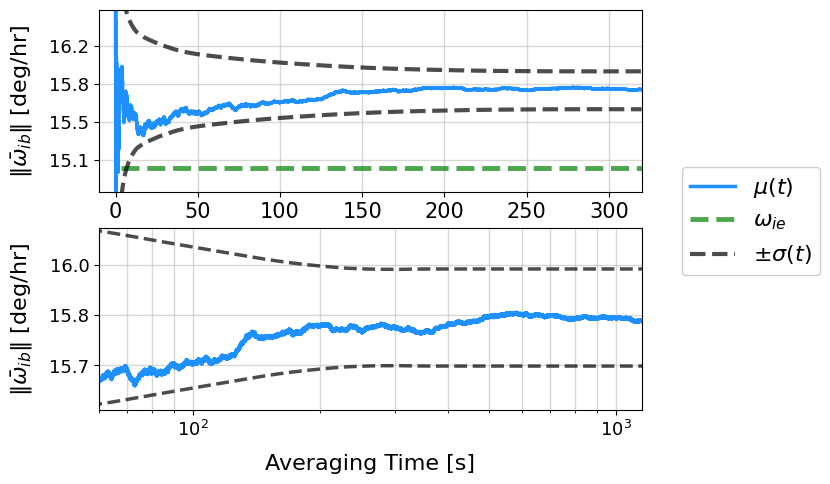

In [ ]:
#@title

fig, ax = plt.subplots(2, figsize=(7, 5.2))
ax[0].plot( x_1_time[::mod_jump], gyr_mn, lw=2.5, c='dodgerblue')
ax[0].axhline( w_ie_GT_Deg, 0.04, 1., ls='--', lw=3.5, c='g', alpha=.7)
ax[0].plot( x_1_time[t_ix*mod_jump::mod_jump], gyr_mn[x_lim]+gyr_sd*sd_lim,
        x_1_time[t_ix*mod_jump::mod_jump], gyr_mn[x_lim]-gyr_sd*sd_lim, ls='--', lw=3., c='k', alpha=.7);

ax[0].set_xlabel(r'Averaging Time [sec]', fontsize=15, labelpad=10)
ax[0].set_ylabel(r'$\| \bar{\omega}_{ib} \|$ [deg/hr]', fontsize=16, labelpad=10)
ax[0].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[0].set_ylim([0.985*w_ie_GT_Deg, 1.1*w_ie_GT_Deg])
ax[0].set_xlim([-10, 320])
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*3600:.1f}')) # Make decimal representation
ax[0].tick_params(axis='y', which='major', labelsize=13)
ax[0].tick_params(axis='x', which='major', labelsize=15)
ax[0].legend(['$\mu(t)$', '$\omega_{ie}$', '$\pm \sigma (t)$'], loc='upper right',
               framealpha=0.95, fontsize=16, fancybox=True, bbox_to_anchor=(1.35, 0.2));

# ---------------- Secondary y-axis ---------------- #
ax[1].semilogx( x_1_time[::mod_jump], gyr_mn, lw=3., c='dodgerblue')
sd_lim = 2.2
x_lim = 50000
ax[1].semilogx( x_1_time[t_ix*mod_jump::mod_jump], gyr_mn[x_lim]+gyr_sd*sd_lim,
        x_1_time[t_ix*mod_jump::mod_jump], gyr_mn[x_lim]-gyr_sd*sd_lim, ls='--', lw=2.5, c='k', alpha=.7);

ax[1].set_xlabel(r'Averaging Time [s]', fontsize=16, labelpad=10)
ax[1].grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax[1].set_ylabel(r'$\| \bar{\omega}_{ib} \|$ [deg/hr]', fontsize=16, labelpad=10)
ax[1].set_ylim([15.5/3600, 16.15/3600])
ax[1].set_xlim([60, 1150])
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*3600:.1f}')) # Make decimal representation
ax[1].tick_params(axis='both', which='major', labelsize=13)

####$\text{Baseline}$

* Using conventional sample mean to compute the gyrocompassing accuracy.

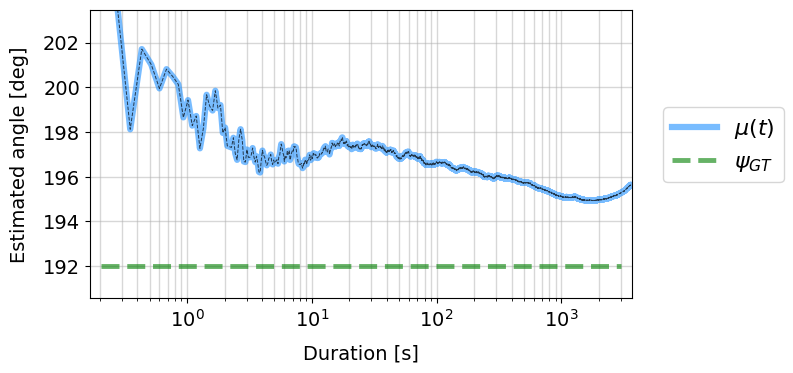

In [ ]:
#@title
GC_MA = np.loadtxt(os.getcwd()+'/Data/x_GC_MA.csv', delimiter=',')

GC_dt = 3600/GC_MA.shape[0]
GC_time = np.arange(GC_dt, 3600, GC_dt)
t_skip = 5

x_0 = 15
fig, ax = plt.subplots(figsize=(7, 3.75))
ax.semilogx( GC_time[x_0::t_skip], GC_MA[x_0::t_skip], lw=4.5, c='dodgerblue', ls='-', alpha=0.6)
ax.axhline( 192, 0.02, 0.98, ls='--', lw=3.5, c='g', alpha=.6)
ax.semilogx( GC_time[x_0::t_skip], GC_MA[x_0::t_skip], lw=0.7, c='k', ls='--', alpha=0.7)

ax.set_xlabel(r'Duration [s]', fontsize=14, labelpad=10)
ax.set_ylabel(r'Estimated angle [deg]', fontsize=14, labelpad=10)
ax.grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim([0.974*GC_MA[-1], 1.04*GC_MA[-1]])
ax.set_xlim([-70, 3700])
ax.legend([r'$\mu(t)$', r'$\psi_{GT}$'], loc='upper right', fontsize=16, fancybox=True, bbox_to_anchor=(1.3, 0.7))

$\text{A representative sample}$

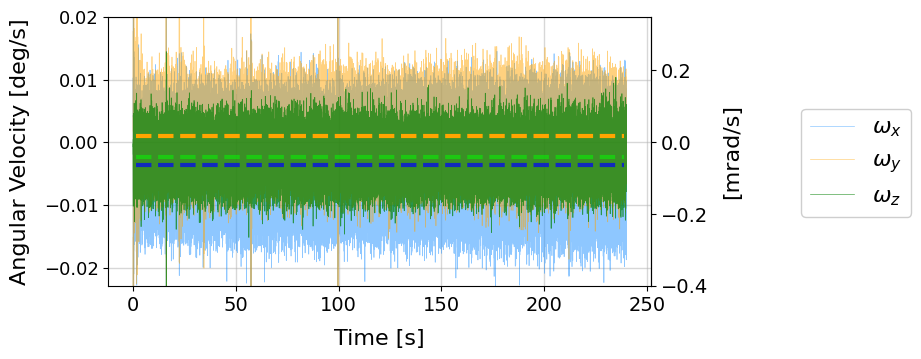

In [ ]:
#@title
t_4_mn = np.arange(0, 240, CFG.dt)
x_4_mn = x_gyr_hr[:t_4_mn.shape[0]]

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot( t_4_mn, x_4_mn[:,0], ls='-', lw=.5, alpha=.5, c='dodgerblue');
ax.plot( t_4_mn, x_4_mn[:,1], ls='-', lw=.5, alpha=.5, c='orange');
ax.plot( t_4_mn, x_4_mn[:,2], ls='-', lw=.5, alpha=.7, c='green');

x_min, x_max = 0.05, 0.95
ax.axhline(x_4_mn[:,0].mean(), x_min, x_max, ls='--', lw=3., c='blue', alpha=.7);
ax.axhline(x_4_mn[:,1].mean(), x_min, x_max, ls='--', lw=3., c='orange');
ax.axhline(x_4_mn[:,2].mean(), x_min, x_max, ls='--', lw=3., c='lime', alpha=.5);

ax.set_xlabel(r'Time [s]', fontsize=16, labelpad=10)
ax.set_ylabel(r'Angular Velocity [deg/s]', fontsize=16, labelpad=10)
ax.grid(True, which='both', ls='-', lw=1., alpha=0.5)
ax.set_ylim([-0.023, +0.020]); # ax.set_xlim([-10, 300])

# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*1000:.1f}')) # Make decimal representation

ax.tick_params(axis='y', which='major', labelsize=13)
ax.tick_params(axis='x', which='major', labelsize=14)

# ---------------- Secondary y-axis ---------------- #
secay = ax.secondary_yaxis('right', functions=(deg_2_mrad, deg_2_mrad))
secay.set_ylabel(r'[mrad/s]', fontsize=16, labelpad=10)
secay.tick_params(axis='both', which='major', labelsize=14)

ax.legend([r'$\omega_x$', r'$\omega_y$', r'$\omega_z$'], loc='upper right', framealpha=0.95, fontsize=16, fancybox=True, bbox_to_anchor=(1.5, 0.7));

### $\text{Execution}$

* $\text{Hyperparameter selection}$
* In this notebook that selected hyper-parameter combindation is:

Time | t_len | DS_factor | AUG_factor | Batch_size | hidden_size | learn_rate | Baseline [deg] | Ours [deg] | Ratio [%] | Epoch
-------------------|------------------|-------------------|-------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|
240 | 14400 | 500 | 300 | 100 | 4  | 0.0015 | 4.51 | 1.82 | 40.354 | 585

Choose duration in **seconds**:

#### $\text{Coarse alignment theory}$

This section comprises both elementary algorithms required for the self-alignment procedures.

$\text{Accelerometer Leveling:}$

Should only be accepted when vehicle is not maneuvering, thus $\ \textbf{f}_{ib}^b=|\textbf{g}^n|$ :

$$
\phi_{nb} = \arctan_2 \big( -f_{ib,y}^b \, , \, -f_{ib,z}^b \big) \hspace{2cm}
\theta_{nb} = \arctan \big( \, \frac{-f_{ib,x}^b}{ \sqrt{f_{ib,y}^b{}^2 + f_{ib,z}^b{}^2} } \, \big) \\
$$

In [ ]:
#@title

def R_b2n(phi, theta, psi):
    """Euler angles from Body to Navigation DCM"""
    Rx = np.array(
         [[1,              0,              0   ],
          [0,	    np.cos(phi),    np.sin(phi)],
          [0,      -np.sin(phi),    np.cos(phi)]])

    Ry = np.array(
         [[ np.cos(theta),   0,    -np.sin(theta)],
          [ 0,               1,              0    ],
          [ np.sin(theta),   0,     np.cos(theta)]])

    Rz = np.array(
         [[ np.cos(psi),   np.sin(psi),     0    ],
          [-np.sin(psi),   np.cos(psi),     0    ],
          [0,                        0,     1    ]])
    return Rz.T@Ry.T@Rx.T


def R_n2b(phi, theta, psi):
    """Euler angles from Navigation to Body DCM"""
    Rx = np.array(
         [[1,              0,              0   ],
          [0,	    np.cos(phi),    np.sin(phi)],
          [0,      -np.sin(phi),    np.cos(phi)]])

    Ry = np.array(
         [[ np.cos(theta),   0,    -np.sin(theta)],
          [ 0,               1,              0    ],
          [ np.sin(theta),   0,     np.cos(theta)]])

    Rz = np.array(
         [[ np.cos(psi),   np.sin(psi),     0    ],
          [-np.sin(psi),   np.cos(psi),     0    ],
          [0,                        0,     1    ]])
    return Rx@Ry@Rz


def R_e2n(lat, long):
    """Global frame (ECEF) to Navigatgion frame (LLLN)"""
    return np.array(
        [[-np.sin(lat)*np.cos(long),   -np.sin(lat)*np.sin(long),  np.cos(lat)],
         [-np.sin(long),                np.cos(long),                        0],
         [-np.cos(lat)*np.cos(long),   -np.cos(lat)*np.sin(long), -np.sin(lat)]])


def levelling( f_ib ): # << check if g_sign neccessary ?!
    ''' input : specific force measurements (negative-g (-9.8) ? flips sign !)
        output: pitch and roll angles
    '''
    phi   = np.arctan2( -f_ib[:,1], -f_ib[:,2] )
    theta = np.arctan(  f_ib[:,0] / np.sqrt( f_ib[:,1]**2 + f_ib[:,2]**2 ) )
    return phi.mean()*CFG.Rad_2_Deg, theta.mean()*CFG.Rad_2_Deg

#### $\text{Gyrocompassing}$

General case:
$$
\begin{align} \hspace{4cm}
\sin \psi_{nb} &= -\omega_{ib,y}^b \cos \phi_{nb} + \omega_{ib,z}^b \sin \phi_{nb} \\
\cos \psi_{nb} &= \hspace{3.5mm} \omega_{ib,x}^b \cos \theta_{nb} + \omega_{ib,y}^b \sin \phi_{nb} \sin \theta_{nb} + \omega_{ib,z}^b \cos \phi_{nb} \sin \theta_{nb}
\end{align}
$$
Such that:
$$
\begin{align}
\underline{\psi_{nb}} &= \arctan_2 \big( \sin \psi_{nb} \, , \, \cos \psi_{nb} \big)
\end{align}
$$

In [ ]:
#@title

def GC_Mean( Gyro, f_ib=None, phi=0, theta=0 ):                  # Groves Alignment method
    """ Input:
            1. Noisy gyroscope measurement R^{n x 3} [deg/s]
            2. Roll and pitch angles (optional)
        Output:
            1. Calculated GC heading angle [deg]
    """

    gyr = Gyro.mean(0)*CFG.Deg_2_Rad        # Convert to radian & average
    if f_ib is None: # <==> == []
        phi, theta = 0, 0
    else:
        phi, theta = levelling( f_ib )

    sin_psi = -gyr[1]*np.cos( phi )   + gyr[2]*np.sin( phi )
    cos_psi =  gyr[0]*np.cos( theta ) + gyr[1]*np.sin( phi )*np.sin( theta ) + gyr[2]*np.cos( phi )*np.sin( theta )
    psi_GC  =  rad_2_deg( np.arctan2( sin_psi, cos_psi ) ) % 360
    return psi_GC

#### $\text{Upload Recordings}$

In [ ]:
#@title
paths_train = glob.glob( '/content/gdrive/MyDrive/Project - EMCORE/Data/Train/*/**.csv', recursive = True);
n_train_valid = len(paths_train)

# Sort ascending according to angle
y_sort = []
for i in range(n_train_valid):
    c_0, c_f = paths_train[i].find('/x_')+3, paths_train[i].find('.')
    c_str = paths_train[i][c_0:c_f]
    y_sort.append( np.float32(c_str) )

y_train_valid = np.array(y_sort)
paths_idx = np.argsort(y_train_valid); y_train_valid.sort()

paths_sort = []
for i in range(n_train_valid): paths_sort.append( paths_train[paths_idx[i]] )

X_df = [];
x_gyr_train_valid, x_acc_train_valid = np.zeros((n_train_valid, CFG.t_len, 3)), np.zeros((n_train_valid, CFG.t_len, 3))

for i, path_i in enumerate( paths_sort[:n_train_valid] ):
    df = pd.read_csv( path_i ) # df.isnull().values.any().sum() ) ) # <-- check for NaNs
    df = df.loc[:CFG.t_len-1, ~df.columns.str.contains('^Unnamed')].dropna(how='all').reset_index(drop=True)

    # Gyroscope & Accelerometer | Data
    X_df.append( df.loc[:, ['w_x', 'w_y', 'w_z', 'f_x', 'f_y', 'f_z']] )
    x_gyr_train_valid[i], x_acc_train_valid[i] = X_df[i][['w_x', 'w_y', 'w_z']].values.astype(None), X_df[i][['f_x', 'f_y', 'f_z']].values.astype(None)

    ggyr = x_gyr_train_valid[i].mean(0)
    y_GT, y_GC = y_train_valid[i], GC_Mean( x_gyr_train_valid[i] )%360

    print('{:2d}) GT: {}  \t GC: {:.1f} \t err: {:.1f} \t (w_x, w_y, w_z) = ({:.4f}, {:.4f}, {:.4f}) \t |w_ib|: {:.2f}'.format(
        i+1, y_GT, y_GC, y_GT-y_GC, ggyr[0], ggyr[1], ggyr[2], Sec_2_hr( f_norm(x_gyr_train_valid[i].mean(0))) ) )

 1) GT: 1.0  	 GC: 4.8 	 err: -3.8 	 (w_x, w_y, w_z) = (0.0032, -0.0003, -0.0021) 	 |w_ib|: 13.70
 2) GT: 8.0  	 GC: 12.1 	 err: -4.1 	 (w_x, w_y, w_z) = (0.0032, -0.0007, -0.0021) 	 |w_ib|: 13.90
 3) GT: 15.0  	 GC: 18.0 	 err: -3.0 	 (w_x, w_y, w_z) = (0.0031, -0.0010, -0.0020) 	 |w_ib|: 13.79
 4) GT: 20.0  	 GC: 24.1 	 err: -4.1 	 (w_x, w_y, w_z) = (0.0031, -0.0014, -0.0021) 	 |w_ib|: 14.33
 5) GT: 25.0  	 GC: 31.0 	 err: -6.0 	 (w_x, w_y, w_z) = (0.0030, -0.0018, -0.0021) 	 |w_ib|: 14.59
 6) GT: 32.0  	 GC: 35.6 	 err: -3.6 	 (w_x, w_y, w_z) = (0.0029, -0.0021, -0.0021) 	 |w_ib|: 15.08
 7) GT: 44.0  	 GC: 41.3 	 err: 2.7 	 (w_x, w_y, w_z) = (0.0027, -0.0024, -0.0021) 	 |w_ib|: 15.07
 8) GT: 50.0  	 GC: 46.2 	 err: 3.8 	 (w_x, w_y, w_z) = (0.0026, -0.0027, -0.0021) 	 |w_ib|: 15.35
 9) GT: 56.0  	 GC: 51.2 	 err: 4.8 	 (w_x, w_y, w_z) = (0.0024, -0.0030, -0.0020) 	 |w_ib|: 15.53
10) GT: 62.0  	 GC: 56.8 	 err: 5.2 	 (w_x, w_y, w_z) = (0.0021, -0.0032, -0.0021) 	 |w_ib|: 15.67
11) GT:

* $\text{Test set}$

In [ ]:
paths_test = glob.glob( '/content/gdrive/MyDrive/Project - EMCORE/Data/Test/*/**.csv', recursive = True);
t_len_test = len(pd.read_csv( paths_test[0] ));
n_test = len(paths_test)

# Sort ascending according to angle
y_sort = []
for i in range(n_test):
    c_0, c_f = paths_test[i].find('/x_')+3, paths_test[i].find('.')
    c_str = paths_test[i][c_0:c_f]
    y_sort.append( np.float32(c_str) )

y_test = np.array(y_sort)
paths_idx = np.argsort(y_test); y_test.sort()

paths_sort = []
for i in range(n_test): paths_sort.append( paths_test[paths_idx[i]] )

X_df = []; x_gyr_test, x_acc_test = np.zeros((n_test, t_len_test, 3)), np.zeros((n_test, t_len_test, 3))

for i, path_i in enumerate( paths_sort[:n_test] ):
    df = pd.read_csv( path_i ) #, index_col=0 ) # df.isnull().values.any().sum()
    df = df.loc[:t_len_test-1, ~df.columns.str.contains('^Unnamed')].dropna(how='all').reset_index(drop=True)

    # Gyroscope & Accelerometer | Data
    X_df.append( df.loc[:, ['w_x', 'w_y', 'w_z', 'f_x', 'f_y', 'f_z']] )
    x_gyr_test[i], x_acc_test[i] = X_df[i][['w_x', 'w_y', 'w_z']].values.astype(None), X_df[i][['f_x', 'f_y', 'f_z']].values.astype(None)

    ggyr = x_gyr_test[i].mean(0)
    y_GT, y_GC = y_test[i], GC_Mean( x_gyr_test[i] ) % 360

    print('{:2d}) GT: {} \t GC: {:.1f} \t err: {:.1f} \t (w_x, w_y, w_z) = ({:.4f}, {:.4f}, {:.4f}) \t |w_ib|: {:.2f}'.format(
        i+1, y_GT, y_GC, y_GT-y_GC, ggyr[0], ggyr[1], ggyr[2], Sec_2_hr( f_norm(x_gyr_test[i].mean(0))) ))

 1) GT: 20.0 	 GC: 24.8 	 err: -4.8 	 (w_x, w_y, w_z) = (0.0032, -0.0015, -0.0023) 	 |w_ib|: 14.98
 2) GT: 22.0 	 GC: 27.2 	 err: -5.2 	 (w_x, w_y, w_z) = (0.0033, -0.0017, -0.0020) 	 |w_ib|: 15.07
 3) GT: 45.0 	 GC: 47.7 	 err: -2.7 	 (w_x, w_y, w_z) = (0.0021, -0.0024, -0.0021) 	 |w_ib|: 13.69
 4) GT: 63.0 	 GC: 58.4 	 err: 4.6 	 (w_x, w_y, w_z) = (0.0019, -0.0030, -0.0020) 	 |w_ib|: 14.77
 5) GT: 65.0 	 GC: 60.8 	 err: 4.2 	 (w_x, w_y, w_z) = (0.0018, -0.0032, -0.0023) 	 |w_ib|: 15.62
 6) GT: 112.0 	 GC: 118.8 	 err: -6.8 	 (w_x, w_y, w_z) = (-0.0018, -0.0033, -0.0023) 	 |w_ib|: 15.80
 7) GT: 117.0 	 GC: 113.5 	 err: 3.5 	 (w_x, w_y, w_z) = (-0.0012, -0.0027, -0.0023) 	 |w_ib|: 13.36
 8) GT: 125.0 	 GC: 119.2 	 err: 5.8 	 (w_x, w_y, w_z) = (-0.0017, -0.0030, -0.0024) 	 |w_ib|: 15.04
 9) GT: 150.0 	 GC: 146.6 	 err: 3.4 	 (w_x, w_y, w_z) = (-0.0029, -0.0019, -0.0026) 	 |w_ib|: 15.78
10) GT: 170.0 	 GC: 173.5 	 err: -3.5 	 (w_x, w_y, w_z) = (-0.0034, -0.0004, -0.0021) 	 |w_ib|: 14.41


**NOTE:** Roll and pitch angles are less than 0.01, thus can be assumed zero.

In [ ]:
train_set, valid_set, test_set = [], [], []; np.random.seed( np.random.randint(1000) )
idx_train_valid = np.arange( x_gyr_train_valid.shape[0] ); np.random.shuffle(idx_train_valid)
idx_train, idx_valid = idx_train_valid[:int(0.8*n_train_valid)], idx_train_valid[int(0.8*n_train_valid):]

x_train_0, y_train_0 = x_gyr_train_valid[idx_train], y_train_valid[idx_train]
x_valid, y_valid = x_gyr_train_valid[idx_valid], y_train_valid[idx_valid]
x_test , y_test  = x_gyr_test, y_test

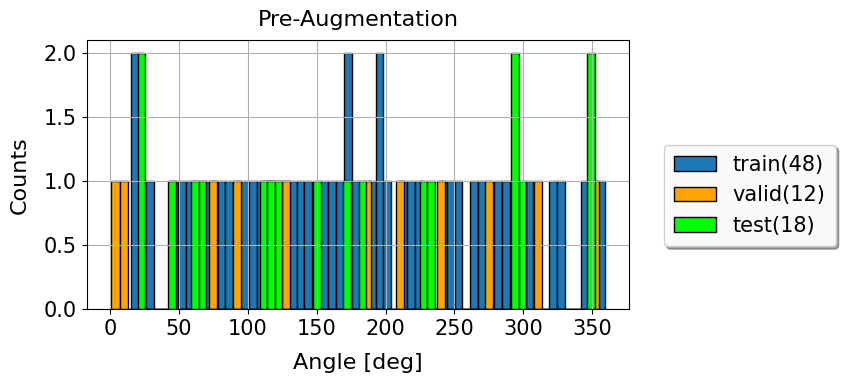

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.hist( y_train_0, bins=60, edgecolor='k', label=r'train({})'.format(y_train_0.shape[0]) );
ax.hist( y_valid, bins=60, color='orange', edgecolor='k', label=r'valid({})'.format(y_valid.shape[0]) );
ax.hist( y_test, bins=60, color='lime', edgecolor='k', label=r'test({})'.format(y_test.shape[0]) );
ax.set_title('Pre-Augmentation', fontsize=16, pad=10);
ax.set_xlabel('Angle [deg]',      fontsize=16, labelpad=10);
ax.set_ylabel('Counts',  fontsize=16, labelpad=10);
ax.tick_params(axis='both', which='major', labelsize=15); ax.grid(True)
ax.legend(fontsize=15, loc='upper right', framealpha=0.95, shadow=True, borderpad=0.5, bbox_to_anchor=(1.4, 0.65));

$\text{Augmentation algorithm}$

1) Downsampling : choose decimation factor

2) Augmentation : choose  of $\Delta \psi$ and noise density  (training ONLY)

3) Batch splitting : choose batch size

In [ ]:
def Downsampling( arr, DS_len ):
    '''
        Input : data
        Output: downsampled data by a decimation factor (DS)
    '''

    d_1, d_2, d_3 = arr.shape[0], arr.shape[1], arr.shape[2]
    arr_DS = np.zeros((d_1, DS_len, d_3))
    for i in range( d_1 ):
        for j in range( d_3 ):
            arr_DS[i,:,j] = signal.decimate(arr[i,:,j], int(d_2/DS_len))

    return arr_DS


# To expedite computation times, pre-saved files are uploaded.
x_train_DS = np.loadtxt(os.getcwd()+'/Data/Augmentations/x_train_DS', delimiter=',').reshape((14400, 276, 3))
y_train_DS = np.loadtxt(os.getcwd()+'/Data/Augmentations/y_train_DS', delimiter=',')

DS_factor = 500                                             # Decimation factor
DS_len = int(CFG.t_len/DS_factor)

x_valid_DS = Downsampling( x_valid, DS_len ); y_valid_DS = y_valid
max_test_idx = DS_len*int(x_test.shape[1]//DS_len)
x_test_DS = Downsampling( x_test[:, :max_test_idx,:], DS_len ); y_test_DS  = y_test # <-- Maximum int() Multiplier

$\text{Labels distribution after augmentation}$

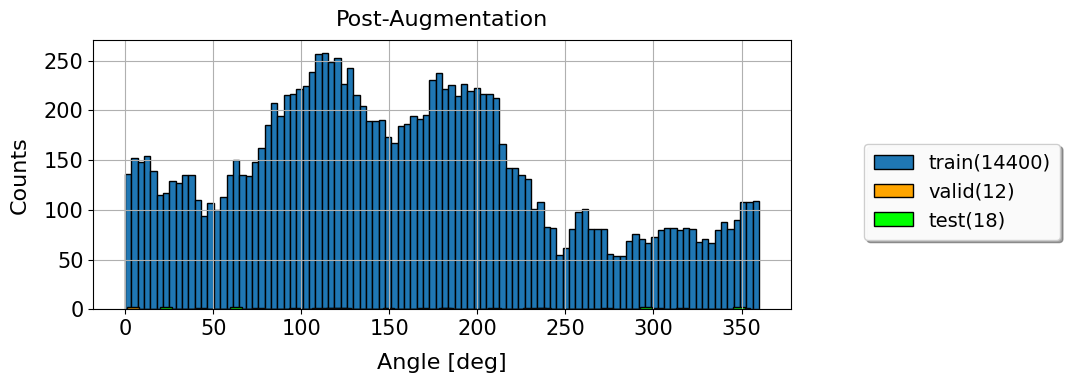

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(9, 3.5))
ax.hist( y_train_DS, bins=100, edgecolor='k', label=r'train({})'.format(y_train_DS.shape[0]) );
ax.hist( y_valid_DS, bins=50, color='orange', edgecolor='k', label=r'valid({})'.format(y_valid.shape[0]) );
ax.hist( y_test_DS, bins=50, color='lime', edgecolor='k', label=r'test({})'.format(y_test.shape[0]) );
ax.set_title('Post-Augmentation', fontsize=16, pad=10);
ax.set_xlabel('Angle [deg]',      fontsize=16, labelpad=10);
ax.set_ylabel('Counts',  fontsize=16, labelpad=10);
ax.tick_params(axis='both', which='major', labelsize=15); ax.grid(True)
# ax.set_ylim(top=3)
ax.legend(fontsize=14, loc='upper right', framealpha=0.95, shadow=True, borderpad=0.5, bbox_to_anchor=(1.4, 0.65));

$\text{Calculate and compare GC Errors}$

In [ ]:
#@title
def GC_error( GT_i, y_GC ):
    '''
    Ensure that error aligns with 360 deg unity circle

    '''
    err_GC = GT_i - y_GC
    if   err_GC > +180: err_GC -= 360
    elif err_GC < -180: err_GC += 360
    return err_GC


def batch_error( x_input, y_GT ):
    '''
    Input : batch of samples [deg/s]
    Output: batch of outputs [deg]
    '''
    err_GC_val = np.zeros(y_GT.shape[0])
    for i, y_GT_i in enumerate(y_GT):
        y_GC = GC_Mean(x_input[i]) % 360
        err_GC_val[i] = GC_error(y_GT_i, y_GC)
    return np.sqrt( np.mean( err_GC_val**2 ) ) # RMSE [deg]

GC_trn_loss = batch_error( x_train_0, y_train_0 )
GC_trn_loss_DS = batch_error( x_train_DS, y_train_DS )
GC_val_loss = batch_error( x_valid, y_valid )

$\text{Error distribution after augmentation}$

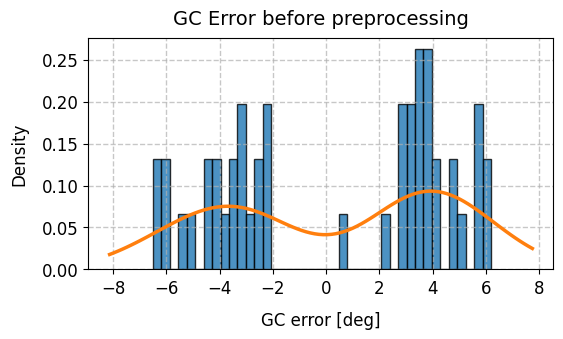

In [ ]:
#@title
err_GC_trn = np.zeros( x_train_0.shape[0] )
for i, GT_i in enumerate(y_train_0):
    y_GC = GC_Mean( x_train_0[i] ) % 360
    err_GC_trn[i] = GC_error( GT_i, y_GC )

kde = stats.gaussian_kde( err_GC_trn )
xx = np.linspace(err_GC_trn.min()*1.25, err_GC_trn.max()*1.25, 100)

fig, ax = plt.subplots(figsize=(6, 3.))
ax.hist(err_GC_trn, density=True, bins=40, alpha=0.8, edgecolor='k')
ax.set_title('GC Error before preprocessing', fontsize=14, pad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=10)
ax.set_xlabel('GC error [deg]', fontsize=12, labelpad=10)
ax.plot(xx, kde(xx), lw=2.5)
ax.tick_params(axis='both', which='major', labelsize=12); ax.grid(True)
ax.grid(True, ls='--', lw=1., alpha=.7)

$\text{Loss function}$

In [ ]:
class cyclicMSE(nn.Module):
    def __init__(self):
        super(cyclicMSE, self).__init__()

    def forward(self, y_GT, y_pred):
        y_GT, y_pred = deg_2_rad( y_GT ), deg_2_rad( y_pred )
        error = torch.atan2( torch.sin(y_GT - y_pred), torch.cos(y_GT - y_pred))
        mse_loss = torch.mean( rad_2_deg( error )** 2 )
        return mse_loss

# angle1, angle2 = torch.tensor(1.0), torch.tensor(359.0)
# cyclicMSE()(angle1, angle2)**.5

$\text{Upload into Dataloaders}$

To improve modularity and automation, measurements are storaged in pre-loaded datasets such that usage during optimization become simpler and quicker.

In [ ]:
def x_preprocess( arr, batch_size=None, is_sample=True ): # <-- check how to omit **batch_size
    '''
        1. Data flattening
        2. Split to batches for improved agility
    '''

    if batch_size is None:
        batch_size=arr.shape[0]

    if is_sample: # Flattening :: Check performances with both AXES
        arr_flatten = torch.flatten(torch.tensor(arr, dtype=torch.float32).permute(0, 2, 1), start_dim=1) # || AXIS 1 <== BEST !
        # arr_flatten = torch.flatten(torch.tensor(arr, dtype=torch.float32), start_dim=1)                # || AXIS 0
    else:
        arr_flatten = torch.tensor(arr, dtype=torch.float32)

    # Split to batches
    piler = torch.split(arr_flatten, batch_size)
    return torch.stack(list(piler), dim=0).to(device)

* Suggested batch-size: 50 ~ 100

In [ ]:
train_batch_size = 100
test_data, test_labels = x_preprocess( x_valid_DS ), x_preprocess(y_valid, is_sample=False).squeeze(0)

###$\text{Inferece phase}$

* Use pretrained model to expedite demonstration.

#### $\text{Model Architecture}$

* Either here, the user is encouraged to examine different heuristics, i pursuit of optimality.

In [ ]:
bidirectional = True
if bidirectional: num_directions = 2
else: num_directions = 1

# Define Hyperparameters
input_size = test_data.shape[-1]
num_epochs = 1000
num_layers = 2
output_size = 1
hidden_size = 12
learning_rate = 0.0015

In [ ]:
class LSTM(nn.Module): # Long short term memory
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size, self.num_layers = hidden_size, num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size*num_directions, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*num_directions, output_size, self.hidden_size, device=x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers*num_directions, output_size, self.hidden_size, device=x.device).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        pred = self.fc(out).squeeze(0).squeeze(1)
        return pred%360

class GRU(nn.Module): # Gated recurrent unit
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU, self).__init__()
        self.hidden_size, self.num_layers = hidden_size, num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size*num_directions, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*num_directions, output_size, self.hidden_size, device=x.device).requires_grad_()
        out, _ = self.gru(x, h0.detach())
        pred = self.fc(out).squeeze(0).squeeze(1)
        return pred%360

class RNN(nn.Module): # Recurrent Neural Network
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size, self.num_layers = hidden_size, num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size*num_directions, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*num_directions, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        pred = self.fc(out).squeeze(0).squeeze(1)
        return pred%360

* $\text{Choose model:}$

In [ ]:
model_choice = 2

In [ ]:
def choose_model( choice: int) -> int:
    ''' Input : choice of model
        Output: model class & preset hyper-parameters
    '''
    # execfile('models_architecture.py')
    args = (input_size, hidden_size, output_size, num_layers)

    if   choice==1:
        model = LSTM(*args).to(device)
    elif choice==2:
        model = GRU(*args).to(device)
    elif choice==3:
        model = RNN(*args).to(device)
    else:
        raise Exception('! Wrong input choice !')
    return model

model = choose_model(model_choice).to(device)

In [ ]:
criterion = cyclicMSE()                             # criterion = nn.MSELoss()
print('\n(*) Model Architechture:\n\n', model)
print('\n(*) Total params:', sum(p.numel() for p in model.parameters()) )


(*) Model Architechture:

 GRU(
  (gru): GRU(828, 12, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

(*) Total params: 63385


* $\text{Training curve (uploaded)}$

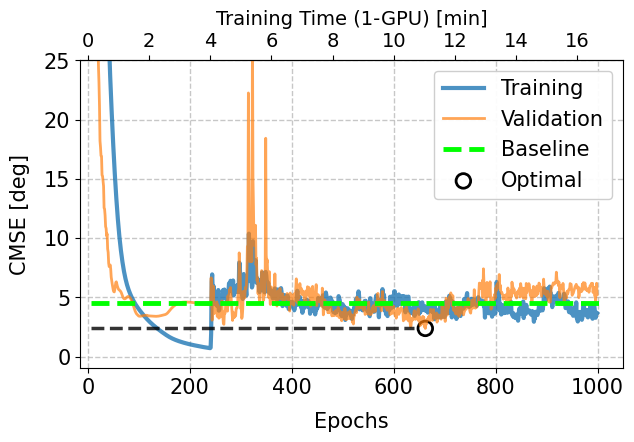

In [ ]:
#@title
Loss_Train = np.loadtxt(os.getcwd()+'/Data/Loss/loss_train.csv', delimiter=',')
Loss_Valid = np.loadtxt(os.getcwd()+'/Data/Loss/loss_valid.csv',  delimiter=',')

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot( Loss_Train, lw=3., alpha=0.8)
ax.plot( Loss_Valid, lw=2., alpha=0.7)
ax.axhline(y=4.51, xmin=0.02, xmax=0.97, c='lime', lw=3.5, ls='--')

ax.scatter(Loss_Valid.argmin(), Loss_Valid.min(), s=110, marker='o', edgecolors='k', lw=2., facecolors='none')#, alpha=.65)
ax.axhline(y=Loss_Valid.min(), xmin=0.02, xmax=Loss_Valid.argmin()/Loss_Valid.shape[0]*.93, c='k', lw=2.5, ls='--', alpha=.8)

ax.set_ylabel('CMSE [deg]', fontsize=15, labelpad=10)
ax.set_xlabel('Epochs', fontsize=15, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=15); ax.grid(True)

secax = ax.secondary_xaxis('top', functions=(lambda x:x/60, lambda x:x/60))
secax.set_xlabel(r'Training Time (1-GPU) [min]', fontsize=14, labelpad=5)
secax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, ls='--', lw=1., alpha=.7)
ax.set_ylim([-1, 25])
ax.set_xlim(left=-15)

ax.legend([r'Training', r'Validation', r'Baseline', r'Optimal'], loc='upper right', framealpha=0.95, fontsize=15, fancybox=True); #, bbox_to_anchor=(1.3, 0.65));

###$\text{Testing phase}$

* Perform model inference over test-set

* Make sure GPU is enabled !

In [ ]:
best_model = torch.load(os.getcwd()+'/Data/Model_Best')
pred_val = best_model( test_data )                    # [deg]
loss_val = criterion( pred_val, test_labels ).item()  # [deg^2]
print('pred: {:.2f} [deg] | GC: {:.2f} [deg]'.format( loss_val**.5, GC_val_loss  ) )

pred: 3.54 [deg] | GC: 3.68 [deg]


$$- \text{ finito la comedia }-$$